Training a LSTM model with ULMFIT approach on original text and then on reversed text. Then ensembaling the predictions of both.

Inpiration source [here](https://www.kaggle.com/gurharkhalsa/backwards-forwards-ulmfit-ensemble).

In [1]:
#!pip install --no-index --find-links="../input/commonlit-pkgs-offline-download" spacy==3.1.1
!pip install spacy==3.1.1

     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 456 kB 9.6 MB/s 
     |████████████████████████████████| 621 kB 9.6 MB/s 
     |████████████████████████████████| 42 kB 680 kB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.7
    Uninstalling spacy-2.3.7:
      Successfully uninstalled spacy-2.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [2]:
#!pip install --no-index --find-links="../input/commonlit-pkgs-offline-download" fastai==2.4.1
!yes Y|conda install -c fastai fastai=2.4.1

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

## Import libraries

In [3]:
import fastai
fastai.__version__

'2.4.1'

In [4]:
from typing import *
from pandas.core.frame import DataFrame
from fastai.text.all import *

In [5]:
path = Path('../input')
op_path = Path('/kaggle/working')
train_path = path/'commonlitreadabilityprize/train.csv'
test_path = path/'commonlitreadabilityprize/test.csv'
aug_path = path/'common-lit-datset-with-synonym-replacement/aug_df.csv'
cbt_path = path/'commonlit-infusing-data-with-same-domain-data/vanilla_comlit_train_infused_with_cbt.csv'
cbt_aug_df_path = path/'commonlit-infusing-data-with-same-domain-data/aug_comlit_infused_with_cbt.csv'

In [6]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_all = pd.concat([df_train, df_test])
df_aug = pd.read_csv(aug_path)
df_cbt = pd.read_csv(cbt_path)
df_cbt_aug = pd.read_csv(cbt_aug_df_path)
df_cbt_subset = df_cbt[:8000]

In [7]:
df_aug.head(1)

,Unnamed: 0,id,url_legal,license,excerpt,target,standard_error
0,0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThe...",-0.340259,0.464009


In [8]:
df_cbt_aug.tail(1)

,Unnamed: 0,excerpt,target
128177,120768,"Knots of gazers and gossips were collected in the churchyard , at the bridge , and at the spot where the hat and pumpkin had been found .The stories of Brouwer , of Bones , and a whole budget of others were called to mind ; and when they had diligently considered them all , and compared them with the symptoms of the present case , they shook their heads , and came to the conclusion that Ichabod had been carried off by the Galloping Hessian .As he was a bachelor , and in nobody 's debt , nobody troubled his head any more about him ; the school was removed to a different quarter of the hollo...",NaN


## Fill nan targets with median value

In [9]:
df_cbt_aug['target'] = df_cbt_aug['target'].fillna(df_cbt_aug['target'].median())

In [10]:
df_cbt_aug.tail(1)

,Unnamed: 0,excerpt,target
128177,120768,"Knots of gazers and gossips were collected in the churchyard , at the bridge , and at the spot where the hat and pumpkin had been found .The stories of Brouwer , of Bones , and a whole budget of others were called to mind ; and when they had diligently considered them all , and compared them with the symptoms of the present case , they shook their heads , and came to the conclusion that Ichabod had been carried off by the Galloping Hessian .As he was a bachelor , and in nobody 's debt , nobody troubled his head any more about him ; the school was removed to a different quarter of the hollo...",-0.913327


In [11]:
df_cbt_aug_subset = df_cbt_aug[:10000]

## The backwards model
Trained on text in reverse order

## The dataloader

In [12]:
dls_lm_back = TextDataLoaders.from_df(df_cbt_subset, text_col='excerpt',
                                      is_lm=True, valid_pct=0.1,
                                      bs=256, seq_len=72, backwards=True)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
dls_lm_back.show_batch(min_n=3)

,text,text_
0,"'' ! blood as red all turned has , is girl the where sea the , why xxmaj ` ` . mother a of anxiety the all with , queen the cried '' ? dear , it is what xxmaj ` ` . excitement obvious in , monarch the exclaimed suddenly '' ! word my xxmaj … ? be he can earth on where .but hand on adventure an is there where","! blood as red all turned has , is girl the where sea the , why xxmaj ` ` . mother a of anxiety the all with , queen the cried '' ? dear , it is what xxmaj ` ` . excitement obvious in , monarch the exclaimed suddenly '' ! word my xxmaj … ? be he can earth on where .but hand on adventure an is there where ,"
1,"her by her held and feet her at himself threw he , saying so '' . lover faithful most your of aid the refuse not .do you hold that hands unworthy the from , princess xxmaj my , you rescue to here me brought who , mermaid friendly a of help unexpected the for but captive a be now even should i where , earth the of end other the to chariot","by her held and feet her at himself threw he , saying so '' . lover faithful most your of aid the refuse not .do you hold that hands unworthy the from , princess xxmaj my , you rescue to here me brought who , mermaid friendly a of help unexpected the for but captive a be now even should i where , earth the of end other the to chariot her"
2,"she then '' . fur your burn n't do you care take only , fire the by down lie ` ` , mother the said '' , bear poor my xxmaj ` ` '' . little a myself warm to wish only and , frozen half am i xxbos '' ! prigio xxmaj prince xxmaj live long xxmaj ` ` : shoute and sword his lifted and , horse his with ,","then '' . fur your burn n't do you care take only , fire the by down lie ` ` , mother the said '' , bear poor my xxmaj ` ` '' . little a myself warm to wish only and , frozen half am i xxbos '' ! prigio xxmaj prince xxmaj live long xxmaj ` ` : shoute and sword his lifted and , horse his with , alive"
3,"` . queen xxmaj the asked '' ? then say you would what , all after , brother your not was he supposing but xxmaj ` ` . him with angry not am i ` ` ; said she '' , madam , no ! ah xxmaj ` ` '' ? it for him punish i .shall out you turned he saw i ` ` ; said she '' , brother bad",". queen xxmaj the asked '' ? then say you would what , all after , brother your not was he supposing but xxmaj ` ` . him with angry not am i ` ` ; said she '' , madam , no ! ah xxmaj ` ` '' ? it for him punish i .shall out you turned he saw i ` ` ; said she '' , brother bad a"
4,"fifty are .here me to one all 's it ` ` , father the said '' , will you what learn xxmaj ` ` '' . living a me gain will which art an of master be shall i way that in and , shudder to learn and out set 'll i then , daylight till wait only ; willingly , father , yes xxmaj ` ` '' . you with do","are .here me to one all 's it ` ` , father the said '' , will you what learn xxmaj ` ` '' . living a me gain will which art an of master be shall i way that in and , shudder to learn and out set 'll i then , daylight till wait only ; willingly , father , yes xxmaj ` ` '' . you with do to"
5,. mother her find to house the in went and chair the on down dolly her put edith xxmaj then xxmaj . longer hour an half for waited she then and ; came helen xxmaj no and four struck clock town big the but xxmaj . waited and table the at chair a in sat she then and xxmaj . two for table the set had nurse her where trees the under,mother her find to house the in went and chair the on down dolly her put edith xxmaj then xxmaj . longer hour an half for waited she then and ; came helen xxmaj no and four struck clock town big the but xxmaj . waited and table the at chair a in sat she then and xxmaj . two for table the set had nurse her where trees the under out
6,"you if -- it know people let to not best it find will you , clever are you .if this remember to induced be never can , children dear my , world the but ; stupid so born being for fault in much as just were people other the ? that for blamed be to he was , -

## The backwards model

In [14]:
learn_back = language_model_learner(dls_lm_back,
                               AWD_LSTM,
                               drop_mult=2.0,
                               metrics=[accuracy, Perplexity()], 
                               path=path,
                              wd=0.5).to_fp16()

## Training the model

In [15]:
learn_back.path = op_path

In [16]:
learn_back.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.505924,4.937426,0.209017,139.410950,02:41


In [17]:
def show_me_lrs(learn):
    suggestions = namedtuple('Suggestions', ["min", "steep",
                                            "valley", "slide"])
    lr_min, lr_steep,lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep,valley, slide))
    suggested_lrs = suggestions(lr_min, lr_steep, lr_valley, lr_slide)
    
    print(f"Minimum/10:\t{lr_min:.2e}\
          \nSteepest point:\t{lr_steep:.2e}\
          \nLongest valley:\t{lr_valley:.2e}\
          \nSlide interval:\t{lr_slide:.2e}")
    
    return suggested_lrs

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	1.20e-02          
Steepest point:	9.12e-07          
Longest valley:	3.63e-03          
Slide interval:	1.32e-02


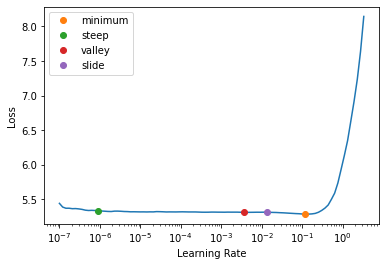

In [18]:
suggested_lrs = show_me_lrs(learn_back)

In [19]:
learn_back.unfreeze()
learn_back.fit_one_cycle(3, suggested_lrs.slide)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.995468,3.271096,0.373703,26.340179,02:55
1,3.056203,2.374376,0.531905,10.744309,02:56
2,2.542395,2.010818,0.613037,7.469425,02:56


good enough accuracy, let;s save it

In [20]:
learn_back.path = Path(".")
learn_back.save_encoder('./back_final_encoder')

## Backward Text regressor

In [21]:
data = DataBlock(
       blocks=(TextBlock.from_df('excerpt', 
                                 vocab=dls_lm_back.vocab, seq_len=72,
                                 backwards=True), RegressionBlock),
       get_x=ColReader('text'),get_y=ColReader('target'),
       splitter=TrainTestSplitter(test_size=0.2))

In [22]:
#data.summary(df_train)

In [23]:
dls_reg_back = data.dataloaders(df_cbt_aug_subset, bs=128)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## The regression model

In [24]:
learn_reg_back = text_classifier_learner(dls_reg_back, AWD_LSTM, drop_mult=2.0,
                                opt_func=QHAdam,
                                metrics=rmse,
                                   wd=1.0).to_fp16()

In [25]:
learn_reg_back.path = Path(".")
learn_reg_back = learn_reg_back.load_encoder('./back_final_encoder')

## Training backwards regresion model

In [26]:
learn_reg_back.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,_rmse,time
0,0.927656,1.129395,1.062730,00:26


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	6.31e-08          
Steepest point:	1.10e-06          
Longest valley:	7.59e-03          
Slide interval:	5.25e-03


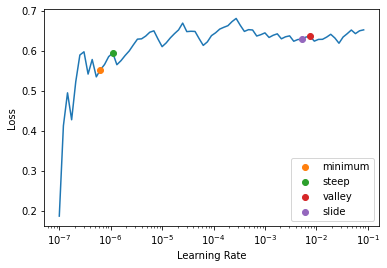

In [27]:
suggested_lrs = show_me_lrs(learn_reg_back)

In [28]:
learn_reg_back.freeze_to(-2)
learn_reg_back.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.588799,0.822445,0.906888,00:29


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	1.32e-03          
Steepest point:	7.59e-07          
Longest valley:	2.09e-03          
Slide interval:	2.09e-03


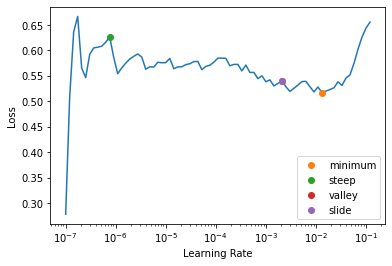

In [29]:
suggested_lrs = show_me_lrs(learn_reg_back)

In [30]:
learn_reg_back.freeze_to(-3)
learn_reg_back.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.506784,0.623313,0.789502,00:42


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	7.59e-08          
Steepest point:	6.31e-07          
Longest valley:	8.32e-04          
Slide interval:	1.74e-03


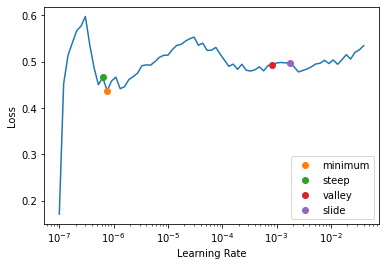

In [31]:
suggested_lrs = show_me_lrs(learn_reg_back)

In [32]:
learn_reg_back.unfreeze()
learn_reg_back.fit_one_cycle(10, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.491824,0.638709,0.799193,00:52
1,0.452594,0.530769,0.728539,00:52
2,0.387039,0.354074,0.595041,00:52
3,0.301843,0.273103,0.522593,00:52
4,0.230964,0.202607,0.450119,00:52
5,0.185799,0.199570,0.446733,00:52
6,0.157325,0.165972,0.407397,00:52
7,0.138069,0.152107,0.390009,00:53
8,0.130502,0.151339,0.389023,00:52
9,0.122204,0.146932,0.383317,00:53


In [33]:
learn_reg_back.export("./back_final_model")

## Create the forward model 

## The dataloader

In [34]:
dls_lm_forward = TextDataLoaders.from_df(df_cbt_subset, text_col='excerpt',
                                      is_lm=True, valid_pct=0.1,
                                      bs=128, seq_len=72, backwards=False)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [35]:
dls_lm_forward.show_batch(min_n=3)

,text,text_
0,"xxbos xxmaj so the xxmaj princess 's days passed very gaily while she waited for the happy time to come .the xxmaj king of the xxmaj sheep , with the help of all the flock , got up balls , concerts , and hunting parties , and even the shadows joined in all the fun , and came , making believe to be their own real selves .one evening , when the","xxmaj so the xxmaj princess 's days passed very gaily while she waited for the happy time to come .the xxmaj king of the xxmaj sheep , with the help of all the flock , got up balls , concerts , and hunting parties , and even the shadows joined in all the fun , and came , making believe to be their own real selves .one evening , when the couriers"
1,"them presents of silver and precious stones , and appointed to meet them at the same hour , in the same place , after a year had passed , to see the little dogs they had brought for him .then they went together to a castle which was about a league from the city , accompanied by all their particular friends , to whom they gave a grand banquet , and the","presents of silver and precious stones , and appointed to meet them at the same hour , in the same place , after a year had passed , to see the little dogs they had brought for him .then they went together to a castle which was about a league from the city , accompanied by all their particular friends , to whom they gave a grand banquet , and the three"
2,"succeeded ; the robber partly led him , and was partly guided by him , right in front of xxmaj cassim 's house , the door of which the robber marked with a piece of chalk .then , well pleased , he bade farewell to xxmaj baba xxmaj mustapha and returned to the forest .by and by xxmaj morgiana , going out , saw the mark the robber had made , quickly","; the robber partly led him , and was partly guided by him , right in front of xxmaj cassim 's house , the door of which the robber marked with a piece of chalk .then , well pleased , he bade farewell to xxmaj baba xxmaj mustapha and returned to the forest .by and by xxmaj morgiana , going out , saw the mark the robber had made , quickly guessed"
3,"each man : ` ` xxmaj as soon as i throw some stones from the window of the chamber where i lie , cut the jars open with your knives and come out , and i will be with you in a trice . '' he returned to the house , and xxmaj morgiana led him to his chamber .she then told xxmaj abdallah , her fellow - slave , to set","man : ` ` xxmaj as soon as i throw some stones from the window of the chamber where i lie , cut the jars open with your knives and come out , and i will be with you in a trice . '' he returned to the house , and xxmaj morgiana led him to his chamber .she then told xxmaj abdallah , her fellow - slave , to set on"
4,"thought of it before . ` ` xxmaj oh ! you 're for a fight , are you ? '' sneered the xxmaj dwarf . ` ` i might tell you to hit one of your own weight , but i ' m not afraid of six of you .yah ! mammy 's brat ! look here , young xxmaj blinkers , i do n't want to hurt you .just turn old","of it before . ` ` xxmaj oh ! you 're for a fight , are you ? '' sneered the xxmaj dwarf . ` ` i might tell you to hit one of your own weight , but i ' m not afraid of six of you .yah ! mammy 's brat ! look here , young xxmaj blinkers , i do n't want to hurt you .just turn old xxmaj"
5,", "" where were you ? "" xxmaj cat says , "" i was at the school . "" xxmaj dog asks , "" which school ? "" xxmaj cat says , "" i was at the school in the village . "" xxmaj dog asks , "" when were you at school ? "" xxmaj cat says , "" i was at school this morning . "" xxmaj dog asks ,",""" where were you ? "" xxmaj cat says , "" i was at the school . "" xxmaj dog asks , "" which school ? "" xxmaj cat says , "" i was at the school in the village . "" xxmaj dog asks , "" when were you at school ? "" xxmaj cat says , "" i was at school this morning . "" xxmaj dog asks , """
6,"saying a word to anyone went straight to the tower , and with her own hand

## The forward Language model

In [36]:
learn_forward = language_model_learner(dls_lm_forward,
                               AWD_LSTM,
                               drop_mult=2.0,
                               metrics=[accuracy, Perplexity()], 
                               path=path,
                              wd=0.5).to_fp16()

In [37]:
learn_forward.path = op_path

In [38]:
learn_forward.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.257883,3.609791,0.307441,36.958321,02:33


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	3.98e-03          
Steepest point:	1.91e-06          
Longest valley:	3.63e-03          
Slide interval:	5.25e-03


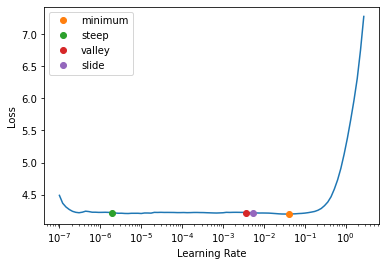

In [39]:
suggested_lrs = show_me_lrs(learn_forward)

In [40]:
learn_forward.unfreeze()
learn_forward.fit_one_cycle(3, suggested_lrs.slide)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.319041,2.771141,0.429629,15.976851,02:50
1,2.735821,2.089844,0.576286,8.083650,02:52
2,2.331531,1.836158,0.637264,6.272393,02:51


In [41]:
learn_forward.path = Path(".")
learn_forward.save_encoder('./forward_final_encoder')

## Forward Text Regressor

In [42]:
data = DataBlock(
       blocks=(TextBlock.from_df('excerpt', 
                                 vocab=dls_lm_forward.vocab, seq_len=72,
                                 backwards=False), RegressionBlock),
       get_x=ColReader('text'),get_y=ColReader('target'),
       splitter=TrainTestSplitter(test_size=0.2))

In [43]:
#data.summary(df_aug)

## The forward dataloader

In [44]:
dls_reg_forward = data.dataloaders(df_cbt_aug_subset, bs=128)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [45]:
dls_reg_forward.show_batch()

,text,text_
0,"xxbos xxmaj the xxmaj queen was inconsolable when she saw this great nose , but her ladies assured her that it was not really as large as it looked ; that it was a xxmaj roman nose , and you had only to open any history to see that every hero has a large nose .the xxmaj queen , who was devoted to her baby , was pleased with what they told her , and when she looked at xxmaj hyacinth again , his nose certainly did not seem to her quite so large .the xxmaj prince was brought up with great care ; and , as soon as he could speak , they told him all sorts of dreadful stories about people who had short noses .no one was allowed to come near him whose nose did not more or less resemble his own , and the courtiers ,",-0.9133265614509583
1,"xxbos ` ` xxmaj if my son has such a long nose as that , '' he said to himself , ` ` he must always see it or feel it ; at least , if he is not blind or without hands . '' but , as the enchanter had vanished , he did not waste any more time in thinking , but went to seek the xxmaj princess , who very soon consented to marry him .but after all , they had not been married very long when the xxmaj king died , and the xxmaj queen had nothing left to care for but her little son , who was called xxmaj hyacinth .the little xxmaj prince had large blue eyes , the prettiest eyes in the world , and a sweet little mouth , but , alas ! his nose was so enormous that it covered half",-0.9133265614509583
2,"xxbos xxmaj the little xxmaj prince had large blue eyes , the prettiest eyes in the world , and a sweet little mouth , but , alas ! his nose was so enormous that it covered half his face .the xxmaj queen was inconsolable when she saw this great nose , but her ladies assured her that it was not really as large as it looked ; that it was a xxmaj roman nose , and you had only to open any history to see that every hero has a large nose .the xxmaj queen , who was devoted to her baby , was pleased with what they told her , and when she looked at xxmaj hyacinth again , his nose certainly did not seem to her quite so large .the xxmaj prince was brought up with great care ; and , as soon as he could speak ,",-0.9133265614509583
3,"xxbos xxmaj the little xxmaj prince had large blue eyes , the prettiest eyes in the world , and a sweet little mouth , but , alas ! his nose was so enormous that it covered half his face .the xxmaj queen was inconsolable when she saw this great nose , but her ladies assured her that it was not really as large as it looked ; that it was a xxmaj roman nose , and you had only to open any history to see that every hero has a large nose .the xxmaj queen , who was devoted to her baby , was pleased with what they told her , and when she looked at xxmaj hyacinth again , his nose certainly did not seem to her quite so large .the xxmaj prince was brought up with great care ; and , as soon as he could speak ,",-0.9133265614509583
4,"xxbos xxmaj people came in from every quarter in great numbers ; they threw water upon the xxmaj princess 's face , unlaced her , struck her on the palms of her hands , and rubbed her temples with xxmaj hungary - water ; but nothing would bring her to herself .and now the xxmaj king , who came up at the noise , bethought himself of the prediction of the fairies , and , judging very well that this must necessarily come to pass , since the fairies had said it , caused the xxmaj princess to be carried into the finest apartment in his palace , and to be laid upon a bed all embroidered with gold and silver .one would have taken her for a little angel , she was so very beautiful ; for her swooning away had not diminished one bit of her complexion ;",-0.9133265614509583
5,"xxbos xxmaj and now the xxmaj king , who came up at the noise , bethought himself of the prediction of the fairies , and , judging very well that this must necessarily come to pass , since the fairies had said it , caused the xxmaj princess to be carried into the finest apartment in his palace , and t

## The regression model

In [46]:
learn_reg_forward = text_classifier_learner(dls_reg_forward, AWD_LSTM, drop_mult=2.0,
                                opt_func=QHAdam,
                                metrics=rmse,
                                   wd=1.0).to_fp16()

In [47]:
learn_reg_forward.path = Path(".")
learn_reg_forward = learn_reg_forward.load_encoder('./forward_final_encoder')

## Training forward regression model

In [48]:
learn_reg_forward.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,1.181329,1.206201,1.098272,00:25


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	3.98e-03          
Steepest point:	1.91e-06          
Longest valley:	4.37e-03          
Slide interval:	5.25e-03


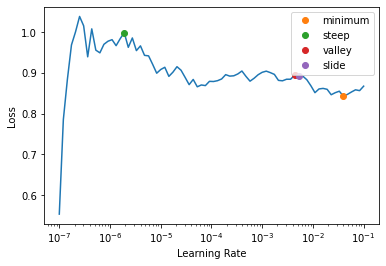

In [49]:
suggested_lrs = show_me_lrs(learn_reg_forward)

In [50]:
learn_reg_forward.freeze_to(-2)
learn_reg_forward.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.696511,1.053715,1.026506,00:29


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	6.31e-08          
Steepest point:	3.98e-06          
Longest valley:	2.51e-03          
Slide interval:	1.45e-03


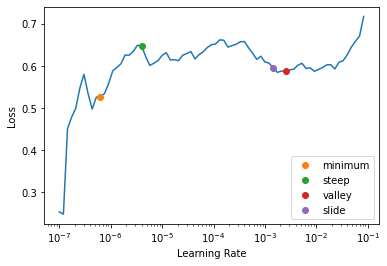

In [51]:
suggested_lrs = show_me_lrs(learn_reg_forward)

In [52]:
learn_reg_forward.freeze_to(-3)
learn_reg_forward.fit_one_cycle(1, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.576376,0.631396,0.794604,00:42


/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Minimum/10:	9.12e-08          
Steepest point:	7.59e-07          
Longest valley:	3.63e-03          
Slide interval:	4.37e-03


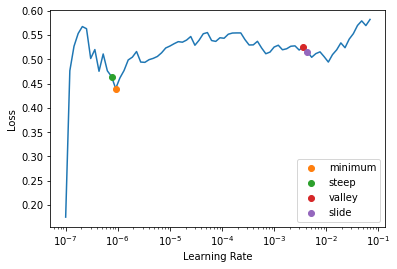

In [53]:
suggested_lrs = show_me_lrs(learn_reg_forward)

In [54]:
learn_reg_forward.unfreeze()
learn_reg_forward.fit_one_cycle(7, suggested_lrs.slide)

epoch,train_loss,valid_loss,_rmse,time
0,0.496892,0.777768,0.881911,00:52
1,0.437635,0.623212,0.789438,00:52
2,0.328843,0.337829,0.581230,00:52
3,0.245727,0.169837,0.412113,00:52
4,0.177968,0.137945,0.371410,00:52
5,0.144356,0.136006,0.368790,00:52
6,0.124360,0.118614,0.344404,00:52


In [55]:
learn_reg_forward.export("./forward_final_model")